## Advanced Lane Finding Project

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from utility import p4
import pickle 

#### Train camera caliberation

In [2]:
f = open('camera_cals.p', 'rb')   
camera_cal = pickle.load(f) 
objpoints = camera_cal['objpoints']
imgpoints = camera_cal['imgpoints']

In [3]:
f = open('perspective_transformation.p', 'rb')
perspective_transformation = pickle.load(f) 
M = perspective_transformation['M']
Minv = perspective_transformation['Minv']

In [4]:
img = plt.imread('./test_images/test6.jpg')

### Apply a distortion correction to raw images.

### Use color transforms, gradients, etc., to create a thresholded binary image.

### Apply a perspective transform to rectify binary image ("birds-eye view").

### Detect lane pixels and fit to find the lane boundary

### Determine the curvature of the lane and vehicle position with respect to center.


### Warp the detected lane boundaries back onto the original image.


### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

fontFace = cv2.FONT_HERSHEY_SIMPLEX
fontScale=1
thickness=2

    
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#    image = util.gaussian_blur(image, 3)
    undistorted = p4.cal_undistort(image, objpoints, imgpoints)
    combined = p4.combinedThresholds(undistorted)
    
    binary_warped = p4.warper(combined, M)
#    closing = cv2.morphologyEx(binary_warped, cv2.MORPH_CLOSE, kernel)
    global left_fitx
    global right_fitx
    left_fitx, right_fitx, left_curverad, right_curverad, out_img, left_fit, right_fit = p4.fitlines(binary_warped, left_fitx, right_fitx,lf_history, rf_history)

    lf.append(left_fit)
    rf.append(right_fit)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = p4.warper(color_warp, Minv) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    middle = int((left_fitx[-1] + right_fitx[-1])//2)
    veh_pos = int(image.shape[1]//2)
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    dx = (veh_pos - middle)*xm_per_pix 
    
    #draw position lines    
    cv2.line(result, (veh_pos, 400), (veh_pos, 720), (255,0,0),2)
    cv2.line(result, (veh_pos-20, 400), (veh_pos+20, 400), (200,200,200),2)
    cv2.line(result, (veh_pos-30, 450), (veh_pos+30, 450), (200,200,200),2)
    cv2.line(result, (veh_pos-20, 500), (veh_pos+20, 500), (200,200,200),2)
    cv2.line(result, (middle, 550), (middle, 720), (200,200,200),4)

    img_out=np.zeros((576,1280,3), dtype=np.uint8)
    img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(combined,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(combined,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(combined,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(out_img,(256,266))
#    global path
#    global counter
#    cv2.imwrite('images/{}/{}.jpg'.format(path, counter), image)
#    counter += 1
    
    #Write curvature and center in image
    TextL = "Left  curv: {:>.1f} km".format(left_curverad/1000)
    TextR = "Right curv: {:>.1f} km".format(right_curverad/1000)

    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(200,200,200), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(200,200,200), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out,'Position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), 
                        fontFace, fontScale,(200,200,200),thickness,lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye view", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    
    img_out = cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR)
    return img_out

In [15]:
path='project'
counter = 1
lf = []
rf = []
left_fitx= [0,0,0]
right_fitx = [0,0,0]
white_output = 'project_video_processe.mp4'
clip1 = VideoFileClip("project_video.mp4")
lf_history = np.zeros((5,3))
rf_history = np.zeros((5,3))
white_clip = clip1.fl_image(process_image).subclip(35,42) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

8190  -  8252
29252  -  7178
[MoviePy] >>>> Building video project_video_processe.mp4
[MoviePy] Writing video project_video_processe.mp4


  1%|          | 1/176 [00:01<03:06,  1.06s/it]

29252  -  7178


  1%|          | 2/176 [00:01<02:57,  1.02s/it]

29012  -  7453


  2%|▏         | 3/176 [00:02<02:53,  1.00s/it]

28210  -  7498


  2%|▏         | 4/176 [00:03<02:49,  1.02it/s]

28455  -  6678


  3%|▎         | 5/176 [00:04<02:45,  1.03it/s]

29144  -  6168


  3%|▎         | 6/176 [00:05<02:44,  1.03it/s]

29484  -  6021


  4%|▍         | 7/176 [00:06<02:43,  1.04it/s]

27883  -  5920


  5%|▍         | 8/176 [00:07<02:47,  1.00it/s]

28696  -  6670


  5%|▌         | 9/176 [00:08<02:46,  1.00it/s]

29010  -  6541


  6%|▌         | 10/176 [00:09<02:44,  1.01it/s]

30392  -  6934


  6%|▋         | 11/176 [00:10<02:37,  1.05it/s]

29825  -  7120


  7%|▋         | 12/176 [00:11<02:35,  1.05it/s]

31397  -  7436


  7%|▋         | 13/176 [00:12<02:35,  1.05it/s]

30808  -  7883


  8%|▊         | 14/176 [00:13<02:33,  1.05it/s]

29415  -  7209


  9%|▊         | 15/176 [00:14<02:29,  1.08it/s]

29218  -  6869


  9%|▉         | 16/176 [00:15<02:28,  1.07it/s]

29047  -  6318


 10%|▉         | 17/176 [00:16<02:29,  1.06it/s]

29668  -  6208


 10%|█         | 18/176 [00:17<02:26,  1.08it/s]

30975  -  6372


 11%|█         | 19/176 [00:18<02:23,  1.09it/s]

30767  -  6646


 11%|█▏        | 20/176 [00:18<02:22,  1.10it/s]

29982  -  6979


 12%|█▏        | 21/176 [00:19<02:20,  1.11it/s]

30111  -  7393


 12%|█▎        | 22/176 [00:20<02:22,  1.08it/s]

31709  -  7498


 13%|█▎        | 23/176 [00:21<02:22,  1.07it/s]

29704  -  7085


 14%|█▎        | 24/176 [00:22<02:22,  1.06it/s]

29404  -  7168


 14%|█▍        | 25/176 [00:23<02:22,  1.06it/s]

29529  -  6447


 15%|█▍        | 26/176 [00:24<02:23,  1.04it/s]

26630  -  6381


 15%|█▌        | 27/176 [00:25<02:20,  1.06it/s]

27546  -  6115


 16%|█▌        | 28/176 [00:26<02:19,  1.06it/s]

27692  -  5909


 16%|█▋        | 29/176 [00:27<02:17,  1.07it/s]

27986  -  5359


 17%|█▋        | 30/176 [00:28<02:16,  1.07it/s]

26753  -  6102


 18%|█▊        | 31/176 [00:29<02:14,  1.08it/s]

27668  -  6127


 18%|█▊        | 32/176 [00:30<02:17,  1.05it/s]

28261  -  6603


 19%|█▉        | 33/176 [00:31<02:17,  1.04it/s]

29535  -  6644


 19%|█▉        | 34/176 [00:32<02:15,  1.05it/s]

30195  -  6221


 20%|█▉        | 35/176 [00:33<02:15,  1.04it/s]

30061  -  6428


 20%|██        | 36/176 [00:34<02:14,  1.04it/s]

29867  -  6745


 21%|██        | 37/176 [00:35<02:14,  1.03it/s]

30210  -  6673


 22%|██▏       | 38/176 [00:36<02:14,  1.02it/s]

29227  -  6125


 22%|██▏       | 39/176 [00:37<02:15,  1.01it/s]

29046  -  5847


 23%|██▎       | 40/176 [00:38<02:12,  1.03it/s]

27919  -  5794


 23%|██▎       | 41/176 [00:39<02:10,  1.03it/s]

28280  -  5711


 24%|██▍       | 42/176 [00:40<02:10,  1.03it/s]

28448  -  6023


 24%|██▍       | 43/176 [00:40<02:08,  1.03it/s]

27815  -  5581


 25%|██▌       | 44/176 [00:41<02:08,  1.03it/s]

30198  -  6149


 26%|██▌       | 45/176 [00:42<02:08,  1.02it/s]

31771  -  6285


 26%|██▌       | 46/176 [00:43<02:04,  1.04it/s]

31235  -  6772


 27%|██▋       | 47/176 [00:44<02:01,  1.06it/s]

30307  -  7082


 27%|██▋       | 48/176 [00:45<02:02,  1.05it/s]

28882  -  6501


 28%|██▊       | 49/176 [00:46<02:00,  1.05it/s]

29645  -  6667


 28%|██▊       | 50/176 [00:47<02:01,  1.04it/s]

29166  -  6202


 29%|██▉       | 51/176 [00:48<02:01,  1.03it/s]

29562  -  5537


 30%|██▉       | 52/176 [00:49<02:02,  1.01it/s]

31412  -  5604


 30%|███       | 53/176 [00:50<02:02,  1.00it/s]

29476  -  6176


 31%|███       | 54/176 [00:51<02:02,  1.01s/it]

29186  -  5948


 31%|███▏      | 55/176 [00:52<02:06,  1.05s/it]

29581  -  6479


 32%|███▏      | 56/176 [00:53<02:01,  1.01s/it]

29283  -  6235


 32%|███▏      | 57/176 [00:55<02:06,  1.06s/it]

32240  -  6447


 33%|███▎      | 58/176 [00:56<02:04,  1.06s/it]

34345  -  6823


 34%|███▎      | 59/176 [00:57<02:00,  1.03s/it]

30355  -  6650


 34%|███▍      | 60/176 [00:58<02:01,  1.05s/it]

34180  -  6597


 35%|███▍      | 61/176 [00:59<02:04,  1.08s/it]

34281  -  6263


 35%|███▌      | 62/176 [01:00<02:03,  1.09s/it]

32408  -  5985


 36%|███▌      | 63/176 [01:01<02:01,  1.07s/it]

31227  -  5211


 36%|███▋      | 64/176 [01:02<02:01,  1.08s/it]

33898  -  5764


 37%|███▋      | 65/176 [01:03<02:03,  1.11s/it]

33176  -  6147


 38%|███▊      | 66/176 [01:04<01:58,  1.08s/it]

33525  -  6383


 38%|███▊      | 67/176 [01:05<01:53,  1.04s/it]

33319  -  6212


 39%|███▊      | 68/176 [01:06<01:51,  1.03s/it]

33961  -  7024


 39%|███▉      | 69/176 [01:07<01:48,  1.01s/it]

30198  -  6364


 40%|███▉      | 70/176 [01:08<01:44,  1.01it/s]

33997  -  6943


 40%|████      | 71/176 [01:09<01:42,  1.02it/s]

34201  -  6708


 41%|████      | 72/176 [01:10<01:41,  1.02it/s]

33440  -  6723


 41%|████▏     | 73/176 [01:11<01:37,  1.06it/s]

30692  -  6631


 42%|████▏     | 74/176 [01:12<01:38,  1.04it/s]

30143  -  6368


 43%|████▎     | 75/176 [01:13<01:35,  1.05it/s]

31309  -  6314


 43%|████▎     | 76/176 [01:14<01:34,  1.06it/s]

29261  -  5977


 44%|████▍     | 77/176 [01:15<01:32,  1.07it/s]

29222  -  6457


 44%|████▍     | 78/176 [01:16<01:33,  1.05it/s]

27009  -  6727


 45%|████▍     | 79/176 [01:17<01:30,  1.07it/s]

26610  -  6389


 45%|████▌     | 80/176 [01:17<01:29,  1.07it/s]

25983  -  6185


 46%|████▌     | 81/176 [01:18<01:28,  1.08it/s]

22721  -  7088


 47%|████▋     | 82/176 [01:19<01:27,  1.08it/s]

22193  -  7198


 47%|████▋     | 83/176 [01:20<01:27,  1.06it/s]

22200  -  6849


 48%|████▊     | 84/176 [01:21<01:26,  1.06it/s]

23727  -  7045


 48%|████▊     | 85/176 [01:22<01:25,  1.06it/s]

24405  -  6688


 49%|████▉     | 86/176 [01:23<01:25,  1.05it/s]

26012  -  6485


 49%|████▉     | 87/176 [01:24<01:25,  1.05it/s]

26383  -  6282


 50%|█████     | 88/176 [01:25<01:26,  1.01it/s]

28071  -  7292


 51%|█████     | 89/176 [01:26<01:24,  1.03it/s]

27303  -  7268


 51%|█████     | 90/176 [01:27<01:23,  1.03it/s]

28132  -  8185


 52%|█████▏    | 91/176 [01:28<01:22,  1.03it/s]

25170  -  7890


 52%|█████▏    | 92/176 [01:29<01:20,  1.04it/s]

26287  -  7601


 53%|█████▎    | 93/176 [01:30<01:19,  1.05it/s]

24741  -  7392


 53%|█████▎    | 94/176 [01:31<01:18,  1.05it/s]

24128  -  7175


 54%|█████▍    | 95/176 [01:32<01:16,  1.06it/s]

23916  -  7128


 55%|█████▍    | 96/176 [01:33<01:16,  1.05it/s]

21252  -  7967


 55%|█████▌    | 97/176 [01:34<01:15,  1.05it/s]

19747  -  8450


 56%|█████▌    | 98/176 [01:35<01:13,  1.06it/s]

17735  -  9236


 56%|█████▋    | 99/176 [01:36<01:11,  1.07it/s]

15908  -  9329


 57%|█████▋    | 100/176 [01:36<01:11,  1.06it/s]

14173  -  10450


 57%|█████▋    | 101/176 [01:37<01:10,  1.07it/s]

13000  -  10384


 58%|█████▊    | 102/176 [01:38<01:10,  1.05it/s]

12188  -  11231


 59%|█████▊    | 103/176 [01:39<01:09,  1.05it/s]

12275  -  10797


 59%|█████▉    | 104/176 [01:40<01:08,  1.05it/s]

10603  -  9049


 60%|█████▉    | 105/176 [01:41<01:07,  1.05it/s]

8671  -  8769


 60%|██████    | 106/176 [01:42<01:06,  1.06it/s]

8520  -  8618


 61%|██████    | 107/176 [01:43<01:05,  1.05it/s]

8560  -  8782


 61%|██████▏   | 108/176 [01:44<01:05,  1.05it/s]

8698  -  8299


 62%|██████▏   | 109/176 [01:45<01:03,  1.06it/s]

8948  -  7316


 62%|██████▎   | 110/176 [01:46<01:02,  1.05it/s]

9320  -  6316


 63%|██████▎   | 111/176 [01:47<01:03,  1.03it/s]

9174  -  7226


 64%|██████▎   | 112/176 [01:48<01:02,  1.03it/s]

9335  -  6973


 64%|██████▍   | 113/176 [01:49<01:00,  1.05it/s]

9363  -  6894


 65%|██████▍   | 114/176 [01:50<00:59,  1.04it/s]

8750  -  7267


 65%|██████▌   | 115/176 [01:51<00:58,  1.04it/s]

9305  -  7617


 66%|██████▌   | 116/176 [01:52<00:57,  1.05it/s]

12585  -  6956


 66%|██████▋   | 117/176 [01:53<00:55,  1.06it/s]

11210  -  3297


 67%|██████▋   | 118/176 [01:54<00:55,  1.05it/s]

9182  -  6210


 68%|██████▊   | 119/176 [01:55<00:54,  1.04it/s]

8600  -  6286


 68%|██████▊   | 120/176 [01:56<00:53,  1.05it/s]

9467  -  6266


 69%|██████▉   | 121/176 [01:57<00:52,  1.06it/s]

9517  -  7639


 69%|██████▉   | 122/176 [01:58<00:51,  1.05it/s]

8621  -  8398


 70%|██████▉   | 123/176 [01:58<00:50,  1.04it/s]

7625  -  8444


 70%|███████   | 124/176 [01:59<00:49,  1.05it/s]

7882  -  8176


 71%|███████   | 125/176 [02:00<00:47,  1.06it/s]

7494  -  8601


 72%|███████▏  | 126/176 [02:01<00:47,  1.04it/s]

7296  -  8195


 72%|███████▏  | 127/176 [02:02<00:46,  1.04it/s]

7486  -  7350


 73%|███████▎  | 128/176 [02:03<00:46,  1.03it/s]

8291  -  7879


 73%|███████▎  | 129/176 [02:04<00:45,  1.03it/s]

10271  -  8872


 74%|███████▍  | 130/176 [02:05<00:44,  1.03it/s]

9562  -  11034


 74%|███████▍  | 131/176 [02:06<00:44,  1.02it/s]

7889  -  8647


 75%|███████▌  | 132/176 [02:07<00:42,  1.02it/s]

8027  -  9355


 76%|███████▌  | 133/176 [02:08<00:41,  1.04it/s]

7141  -  8279


 76%|███████▌  | 134/176 [02:09<00:40,  1.05it/s]

7656  -  8588


 77%|███████▋  | 135/176 [02:10<00:39,  1.05it/s]

6816  -  8529


 77%|███████▋  | 136/176 [02:11<00:38,  1.05it/s]

6159  -  9268


 78%|███████▊  | 137/176 [02:12<00:36,  1.06it/s]

6315  -  8111


 78%|███████▊  | 138/176 [02:13<00:36,  1.05it/s]

7329  -  8292


 79%|███████▉  | 139/176 [02:14<00:35,  1.06it/s]

7229  -  10104


 80%|███████▉  | 140/176 [02:15<00:34,  1.05it/s]

7441  -  10633


 80%|████████  | 141/176 [02:16<00:33,  1.03it/s]

6826  -  10329


 81%|████████  | 142/176 [02:17<00:33,  1.03it/s]

6247  -  10030


 81%|████████▏ | 143/176 [02:18<00:31,  1.05it/s]

6900  -  10481


 82%|████████▏ | 144/176 [02:19<00:30,  1.05it/s]

7956  -  8964


 82%|████████▏ | 145/176 [02:20<00:29,  1.06it/s]

10254  -  8749


 83%|████████▎ | 146/176 [02:20<00:28,  1.07it/s]

14232  -  8397


 84%|████████▎ | 147/176 [02:21<00:27,  1.07it/s]

11519  -  9257


 84%|████████▍ | 148/176 [02:22<00:26,  1.07it/s]

12673  -  9347


 85%|████████▍ | 149/176 [02:23<00:25,  1.06it/s]

13939  -  9028


 85%|████████▌ | 150/176 [02:24<00:24,  1.06it/s]

13984  -  8373


 86%|████████▌ | 151/176 [02:25<00:23,  1.07it/s]

12980  -  8199


 86%|████████▋ | 152/176 [02:26<00:22,  1.07it/s]

14901  -  6755


 87%|████████▋ | 153/176 [02:27<00:21,  1.07it/s]

13387  -  6430


 88%|████████▊ | 154/176 [02:28<00:21,  1.05it/s]

15004  -  7470


 88%|████████▊ | 155/176 [02:29<00:19,  1.05it/s]

15884  -  7806


 89%|████████▊ | 156/176 [02:30<00:19,  1.05it/s]

15460  -  8583


 89%|████████▉ | 157/176 [02:31<00:17,  1.06it/s]

16021  -  9846


 90%|████████▉ | 158/176 [02:32<00:17,  1.06it/s]

16515  -  8657


 90%|█████████ | 159/176 [02:33<00:16,  1.06it/s]

19436  -  9579


 91%|█████████ | 160/176 [02:34<00:14,  1.08it/s]

18898  -  9402


 91%|█████████▏| 161/176 [02:35<00:13,  1.08it/s]

19319  -  9005


 92%|█████████▏| 162/176 [02:35<00:12,  1.08it/s]

21583  -  8425


 93%|█████████▎| 163/176 [02:36<00:11,  1.09it/s]

24675  -  7100


 93%|█████████▎| 164/176 [02:37<00:11,  1.09it/s]

28088  -  6175


 94%|█████████▍| 165/176 [02:38<00:10,  1.09it/s]

29137  -  6009


 94%|█████████▍| 166/176 [02:39<00:09,  1.07it/s]

32332  -  6839


 95%|█████████▍| 167/176 [02:40<00:08,  1.06it/s]

32223  -  5895


 95%|█████████▌| 168/176 [02:41<00:07,  1.06it/s]

34990  -  6303


 96%|█████████▌| 169/176 [02:42<00:06,  1.07it/s]

34080  -  6173


 97%|█████████▋| 170/176 [02:43<00:05,  1.07it/s]

35038  -  6721


 97%|█████████▋| 171/176 [02:44<00:04,  1.08it/s]

34781  -  6136


 98%|█████████▊| 172/176 [02:45<00:03,  1.07it/s]

35084  -  6264


 98%|█████████▊| 173/176 [02:46<00:02,  1.07it/s]

36126  -  5702


 99%|█████████▉| 174/176 [02:47<00:01,  1.06it/s]

33520  -  6349


 99%|█████████▉| 175/176 [02:48<00:00,  1.07it/s]

32996  -  6260


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processe.mp4 

CPU times: user 2min 58s, sys: 6.45 s, total: 3min 4s
Wall time: 2min 49s


(177, 3)


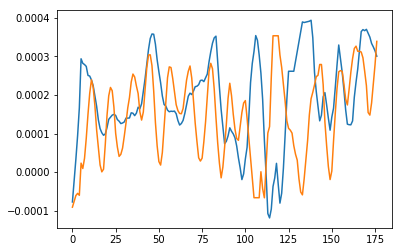

In [7]:
lf = np.array(lf)
rf = np.array(rf)
print(lf.shape)
plt.plot(lf[:,0], label='lf_0')
plt.plot(rf[:,0], label='rf_0')
plt.show()

(177, 3)


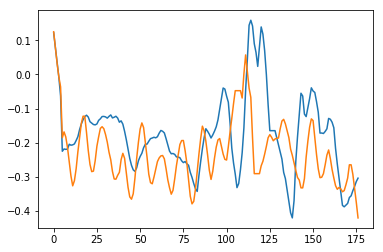

In [8]:
print(lf.shape)
#plt.plot(lf[:,0], label='lf_0')
plt.plot(lf[:,1], label='lf_1')
plt.plot(rf[:,1], label='lf_1')
#plt.plot(lf[:,2], label='lf_2')
plt.show()

(177, 3)


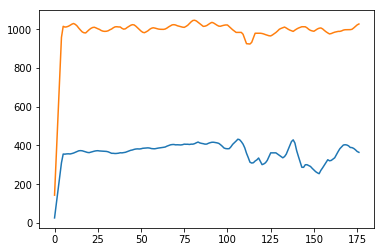

In [9]:
print(lf.shape)
#plt.plot(lf[:,0], label='lf_0')
#plt.plot(lf[:,1], label='lf_1')
plt.plot(lf[:,2], label='lf_2')

plt.plot(rf[:,2], label='lf_1')
plt.show()